# Load packages

In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import cv2

from aespm import *
from utils import *
from tools import *

In [2]:
folder = r"C:\Users\Asylum User\Documents\Asylum Research Data\240415\WTV_AE"

exp = Experiment(folder=folder)

In [3]:
# let's read some useful parameters first

xsens, ysens= read_spm(key=['XLVDTSens', 'YLVDTSens'])
exp.update_param('sensitivity', value=[xsens, ysens])

exp.param['sensitivity']

[9.2639575e-06, 9.9031586e-06]

# Define custom functions

In [4]:
## Commonly used custom functions

# Function to read ibw file
def load_ibw(self, folder="C:\\Users\\Asylum User\\Documents\\AEtesting\\data_exchange"):
    '''
    Read the latest ibw file saved in a given folder.
    '''
    fname = get_files(path=folder, client=self.client)[0]
    return ibw_read(fname, copy=False, connection=self.connection)
exp.add_func(load_ibw)

# Function to convert and rotate the pixels to coordinates
def convert_coord(self, data, coord):
    '''
    Convert the coordinate from pixel to distance.
    Apply rotation if needed.
    '''
    x, y = coord
    
    scan_angle = data.header['ScanAngle']
    
    img = data.data[0] # This is the height channel
    
    # Convert angle to radians
    theta_rad = np.radians(-scan_angle)
    
    # Create 2D rotation matrix
    rot_matrix = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                           [np.sin(theta_rad), np.cos(theta_rad)]])
    
    # Apply the rotation matrix to the coordinates
    center = (np.array(np.shape(img))-1) // 2
    x_rot, y_rot = np.zeros_like(x), np.zeros_like(y)
    for i in range(len(x)):
        x_rot[i], y_rot[i] = np.dot(rot_matrix, (np.array([x[i], y[i]])-center)) + center
    
    # Convert the pixels to the distance
    xpixels, ypixels = data.header['PointsLines'],data.header['ScanPoints']
    xsize, ysize = data.header['FastScanSize'],data.header['SlowScanSize']

    xfactor = xsize / xpixels
    yfactor = ysize / ypixels

    positions = np.zeros([len(x), 2])

    for i in range(len(x)):
        positions[i] = np.array([x_rot[i] * xfactor, y_rot[i] * yfactor])

    # Sort the positions according to x first and y second
    pos_sorted = sorted(positions, key=lambda x: (x[1], x[0]))
    
    p = {
        'ScanAngle': scan_angle,
        'xpixels': xpixels,
        'ypixels': ypixels,
        'xsize': xsize,
        'ysize': ysize,
        'xfactor': xfactor,
        'yfactor': yfactor,
    }
    
    for key in p:
        self.update_param(key=key, value=p[key])
    
    return pos_sorted
exp.add_func(convert_coord)

# Function to move the probe with the given displacement 
def move_probe(self, distance, v0=None, s=None):
    
    # Move the tip to the next location
    move_tip(r=distance, v0=v0, s=s, connection=self.connection)
exp.add_func(move_probe)

# Function to move the probe to the location r and start force distance measurement.
def measure_fd(self, fname, r, v0=None):
    '''
    Move the probe to the location r and start force distance measurement.
    '''
    action_list = [
        ['ChangeName', fname, None], # Change file names
        ['ClearForce', None, None], # Clear any existing force points
        ['GoThere', None, 1], # Move to the center of the image
        ['move_probe', [r], None, {'v0':v0, 's': self.param['sensitivity']}], # Move the tip to location r
        ['SingleForce', None, None], # Start a DART spec
        ['check_files', None, 1], # Check file numbers in the data save folder
    ]
    
    self.execute_sequence(action_list)
exp.add_func(measure_fd)
    
# Function to check the file number in a given folder
def check_files(self):
    return check_file_number(path=self.folder)
exp.add_func(check_files)

# Acquire a topography map

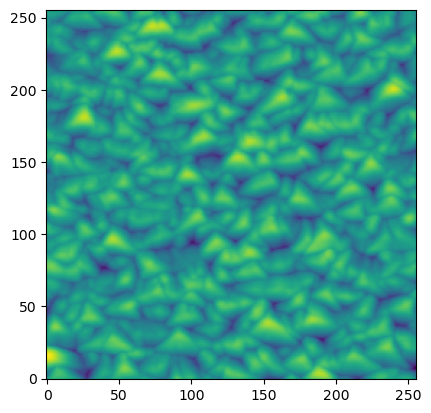

In [5]:
exp.execute('DownScan')
exp.execute('check_files', value=None)

w = exp.load_ibw(folder=exp.folder)

plt.imshow(w.data[0], origin='lower')

# Extract all the edge pixels

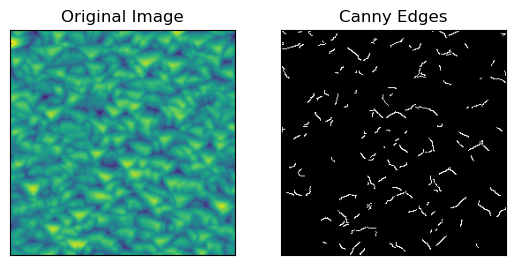

In [6]:
img = np.copy(w.data[0])

# Normalize the image
image = (img-img.min())/img.ptp() * 256
image = image.astype(np.uint8)
# Apply the Canny edge detector
edges = cv2.Canny(image, 150, 200)  # Adjust the threshold values based on your image

# Display the original image and the edges
plt.subplot(121), plt.imshow(image, cmap='viridis')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Canny Edges'), plt.xticks([]), plt.yticks([])

plt.show()

1823


1823

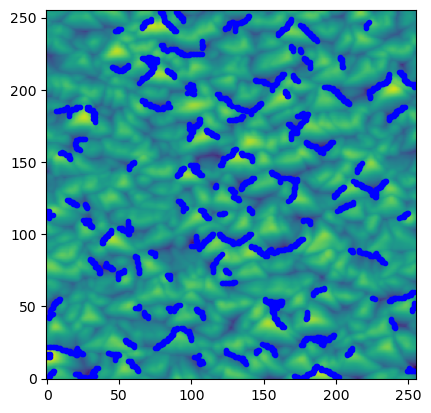

In [7]:
# Adjust the threshold number as needed
y, x = np.where(edges>200)

plt.imshow(img, origin='lower')
plt.plot(x, y, 'b.')
# plt.xlim(0, 50)
# plt.ylim(0, 50)
print(len(x))
len(x)

# Convert the coordinate unit from pixel to distance

In [8]:
pos_sorted = exp.convert_coord(data=w, coord=[x, y])

# Take force spectrum on the edge points

In [ ]:
# Move the probe to the center of the image, and record the X Y sensor readings there
action_list = [
    ['ClearForce', None, None], # Clear any existing force points
    ['GoThere', None, 1], # Move to the center of the image
]

exp.execute_sequence(action_list)

v0 = read_spm(key=['PIDSLoop.0.Setpoint', 'PIDSLoop.1.Setpoint'])

pos0 = np.array([exp.param['xsize']/2, exp.param['ysize']/2])

for i in range(100):
    print("Working on Location {}/{}".format(i, 100), end='\r')
    # Get the next point to measure
    pos_next = pos_sorted[i]
    # Get the distance between next point and current point
    distance_to_move = pos_next - pos0
    
#     exp.execute('measure_fd', value=['FD_loc_{:03}_'.format(i), distance_to_move], v0=v0)
    exp.measure_fd(fname='FD_loc_{:03}_'.format(i), r=distance_to_move, v0=v0)
    